## Getting started

Let's start by importing all the pacakges. If error occurs, please make sure to run `pip install -r requirements.txt`, file which can be find at the root of this repository

In [12]:
import os 
import sys
import inspect

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

import pyLLE
import numpy as np
from scipy import constants as cts
import pandas as pd
import pickle as pkl
import plotly.graph_objs as go
import plotly.graph_objs
import plotly.io as pio
import time
pio.renderers.default = "notebook"
pio.templates.default = "seaborn"

Here we will define the parameters. 2 dictionaries are needed, the resonator and the simulations. Novelty of the version 4 is that the pump power and the pump frequency can be lists to simulate a multi pump system: 

In [13]:
res = dict(
        R=23e-6, 
        Qi=1e6, 
        Qc=1e6, 
        γ=3.2, 
        dispfile="./RW1000_H430.csv"
)

sim = dict(
    Pin=[140e-3], 
    f_pmp=[283e12],
    φ_pmp=[0], 
    δω=[None], 
    Tscan=0.7e6,
    μ_sim=[-220, 220],
    δω_init= 1e9 * 2 * np.pi,
    δω_end= -6.5e9 * 2 * np.pi,
    num_probe = 7000, 
)


In [14]:
solver = pyLLE.LLEsolver(sim=sim, res=res,debug=False)
solver.Analyze()
solver.Setup(verbose = True)
solver.SolveTemporal(bin = "julia-1.11.1/bin/julia", verbose=True)
solver.RetrieveData()

-- Solving standard LLE --
	Simulation Parameters
		R = 23.00 µm
		Qi = 1.00 M
		Qc = 1.00 M
		γ = 3.20 
	Simulation Parameters
		Pin[0] = 140.00 mW
		f_pmp[0] = 282.65 THz
		Tscan = 0.70 x1e6 Round Trip
		μ_sim = [-220.00,220.00] 
		δω_init = 1.00 x2π GHz
		δω_end = -6.50 x2π GHz
		μ_fit = [None,None] 
		δω_stop = -6.50 x2π GHz
		ind_pump_sweep[0] = 0.00 

HDF5 parameter file can be foud in: /tmp/tmp56y7xu3bParamLLEJulia.h5
----------------------------------------------------------------------
2025-01-02 16:45:05
Launching Julia....
Temp file can be found in: /tmp/tmp56y7xu3blog.log
Launching Julia: Done
Computing LLE [**************************************************] 100%

Simulation Time 00h:01min:16.0s
----------------------------------------------------------------------


In [ ]:
ref_spectrum = np.zeros(441)
def calculate_mse(ref_spectrum, spectrum):
    return np.linalg.norm(ref_spectrum - spectrum, ord=2)

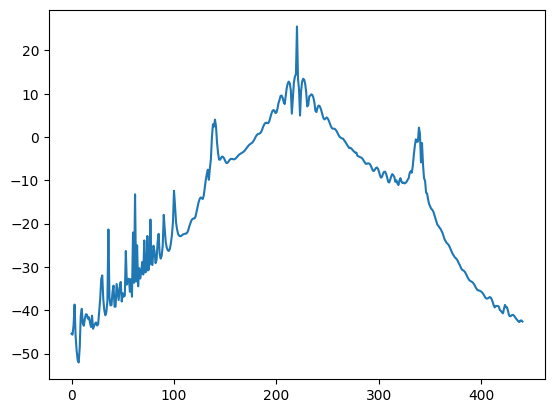

In [18]:
s = solver.sol.Ewg[:,3345]
pred_spec = 10*np.log10(np.abs(s)) + 30
import matplotlib.pyplot as plt
plt.plot(pred_spec)

In [19]:
target_spectrum = pred_spec

In [8]:
from scipy.optimize import differential_evolution

In [ ]:
# Define the simulation and resonator setup
res = dict(
    R=23e-6,
    Qi=1e6,
    Qc=1e6,
    γ=3.2,
    dispfile="./RW1000_H430.csv"
)

sim_template = dict(
    Pin=[290e-3],  # Placeholder, to be optimized
    f_pmp=[283e12],
    φ_pmp=[0],  # Placeholder, to be optimized
    δω=[None],
    Tscan=0.7e6,
    μ_sim=[-220, 220],
    δω_init=1e9 * 2 * np.pi,
    δω_end=-6.5e9 * 2 * np.pi,
    num_probe=7000,
)

# Define the fitness function
def fitness_function(params):
    """
    Compute the fitness score for given Pin and φ_pmp.
    Arguments:
        params: Array containing [Pin, φ_pmp].
    Returns:
        Mean squared error (MSE) between the simulated and reference spectrum.
    """
    Pin = [params[0]]  # Optimized pump power
    φ_pmp = [params[1]]  # Optimized phase

    # Update the simulation parameters
    sim = sim_template.copy()
    sim['Pin'] = Pin
    sim['φ_pmp'] = φ_pmp

    # Solve the LLE
    solver = pyLLE.LLEsolver(sim=sim, res=res, debug=False)
    solver.Analyze()
    solver.Setup(verbose=False)
    solver.SolveTemporal(bin="julia-1.11.1/bin/julia", verbose=False)
    solver.RetrieveData()
    s = solver.sol.Ewg[:,3345]
    spectrum = 10*np.log10(np.abs(s)) + 30

    # Calculate the fitness score (MSE)
    mse = np.linalg.norm(target_spectrum - spectrum, ord=2)
    return mse

# Define bounds for Pin and φ_pmp
bounds = [
    (0.001, 0.5),  # Pump power bounds (adjust based on your system)
    (0, 2*np.pi)  # Phase bounds
]

# Run the Differential Evolution algorithm
result = differential_evolution(
    fitness_function,
    bounds,
    strategy='best1bin',
    maxiter=100,
    popsize=15,
    tol=1e-6,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=42)

# Extract the results
optimal_params = result.x
optimal_fitness = result.fun
print(f"Optimal Parameters: {optimal_params}")
print(f"Optimal Fitness (MSE): {optimal_fitness}")

# Update sim with optimal parameters
optimized_Pin = [optimal_params[0]]
optimized_φ_pmp = [optimal_params[1]]
print(f"Optimized Pump Power (Pin): {optimized_Pin}")
print(f"Optimized Phase (φ_pmp): {optimized_φ_pmp}")